In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
X = pd.read_csv('./dataset/data.csv')
X.shape

(569, 32)

In [36]:
X['diagnosis'] = X['diagnosis'].map({'B': 0, 'M': 1})

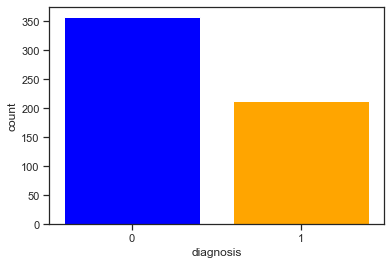

In [37]:
count_per_diagnosis = X.groupby('diagnosis').count().loc[:, 'id'].values
title_names = X.groupby('diagnosis').count().index.array

plt.figure()
plt.bar(np.vectorize(lambda x: str(x))(title_names), count_per_diagnosis, color=['blue', 'orange'])
plt.xlabel('diagnosis')
plt.ylabel('count')
plt.show()

Vrlo, vrlo neupotrebljiv graf koji ništa ne predstavlja.

C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


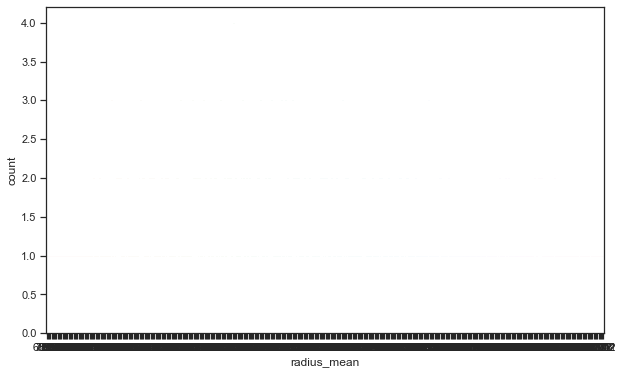

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(X['radius_mean'])

plt.xlabel('radius_mean')
plt.ylabel('count')
plt.show()

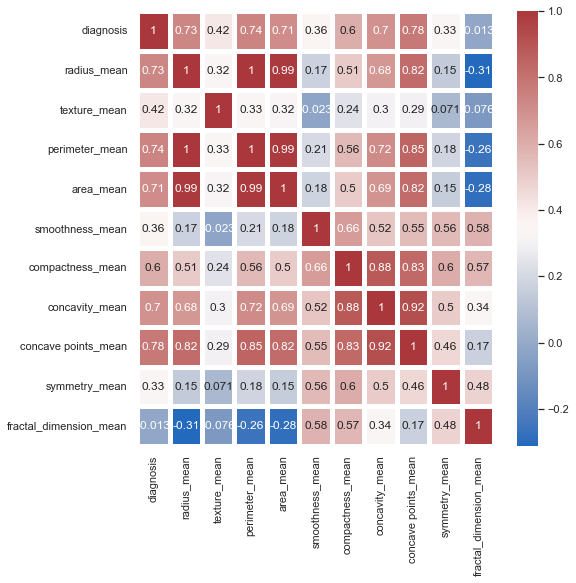

In [39]:
sns.set_theme(style='white')

corr_columns = [col for col in X if col.endswith('mean') or col.startswith('diagnosis')]
corr = X[corr_columns].corr()

plt.subplots(figsize=(8, 8))
sns.heatmap(corr, linewidths=5, annot=True, cmap='vlag')

plt.show()

Ostavljen je id u grafu...

C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


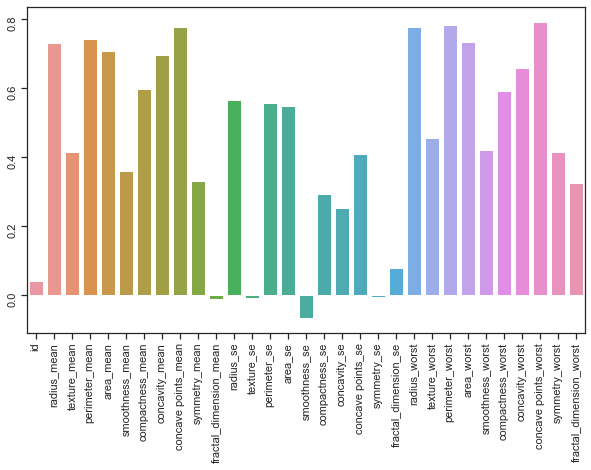

In [40]:
sns.set_style("ticks")

corr_with_target = X.corr()['diagnosis'].drop(labels=['diagnosis'])

plt.figure(figsize=(10, 6))
g = sns.barplot(corr_with_target.index, corr_with_target.values)
g.tick_params(axis='x', rotation=90)
g.tick_params(axis='y', rotation=90)
plt.show()

U tekstu nije navedeno koji se atributi uklanjaju kod feature selectiona.

Dalje uklanjam id, fractal_dimension_mean, texture_se, smoothness_sem symetry_se i fractal_dimension_se

Također skup podataka se dijeli na train i test skupove. Ta se podjela radi nasumično i zadaje se samo omjer.
Ovisno o tom nasumičnom odabiru svi će modeli biti trenirani i testirani na podskupu cijelog skupa podataka koji se razlikuje od onog upotrebljenog u paperu. To znači da modeli neće moći imati identične accuray_score rezultate već će imati približne-


In [41]:
X_trimmed = X.drop(columns=['id', 'fractal_dimension_mean', 'texture_se', 'smoothness_se', 'symmetry_se',
                            'fractal_dimension_se'])

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X_trimmed.drop(columns=['diagnosis']), X['diagnosis'],
                                                    test_size=0.25)


def test_model(model, model_label, mod=None):
    if mod is not None:
        train_accuracy = accuracy_score(y_train, model.predict(mod.fit_transform(X_train)))
        test_accuracy = accuracy_score(y_test, model.predict(mod.fit_transform(X_test)))
    else:
        train_accuracy = accuracy_score(y_train, model.predict(X_train))
        test_accuracy = accuracy_score(y_test, model.predict(X_test))

    print('Algorith {}: Training accuracy={}, Testing accuracy={}\n'.format(model_label, train_accuracy, test_accuracy))

    return {'Algorithms': model_label, 'Training Accuracy': train_accuracy, 'Testing Accuracy': test_accuracy}


def draw_confusion_matrix(model, graph_label, mod=None):
    if mod is None:
        y_generated = model.predict(X_test)
    else:
        y_generated = model.predict(mod.fit_transform(X_test))

    cf_matrix = confusion_matrix(y_test, y_generated)

    sns.heatmap(cf_matrix, annot=True, cmap='Blues', linewidths=5)
    plt.title(graph_label)
    plt.show()

In [43]:
results = pd.DataFrame(columns=['Algorithms', 'Training Accuracy', 'Testing Accuracy'])


In [44]:
from sklearn.linear_model import LogisticRegression

poly = PolynomialFeatures(2).fit(X_train)

log_reg = LogisticRegression(max_iter=5000).fit(poly.transform(X_train), y_train)

results = results.append(test_model(log_reg, 'Logistic regression', poly), ignore_index=True)

Algorith Logistic regression: Training accuracy=0.9882629107981221, Testing accuracy=0.965034965034965



C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5).fit(X_train, y_train)

results = results.append(test_model(knn, 'KNN'), ignore_index=True)


Algorith KNN: Training accuracy=0.9413145539906104, Testing accuracy=0.9300699300699301



In [46]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini').fit(X_train, y_train)

results = results.append(test_model(tree, 'Decision Tree'), ignore_index=True)

Algorith Decision Tree: Training accuracy=1.0, Testing accuracy=0.8811188811188811



In [47]:
from sklearn.naive_bayes import GaussianNB

bayes = GaussianNB().fit(X_train, y_train)

results = results.append(test_model(bayes, 'Naive Bayes'), ignore_index=True)

Algorith Naive Bayes: Training accuracy=0.9483568075117371, Testing accuracy=0.9370629370629371



In [48]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='entropy').fit(X_train, y_train)

results = results.append(test_model(forest, 'Random Forest'), ignore_index=True)

Algorith Random Forest: Training accuracy=1.0, Testing accuracy=0.951048951048951



Konfuzijska matrica u paperu je generirana samo na SVM modelu.

Algorith SVM: Training accuracy=1.0, Testing accuracy=0.972027972027972



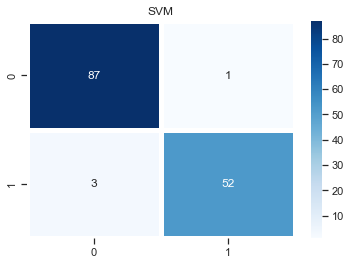

In [49]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

svm = SVC(kernel='rbf', C=80).fit(scaler.transform(X_train), y_train)

results = results.append(test_model(svm, 'SVM', scaler), ignore_index=True)
draw_confusion_matrix(svm, 'SVM', scaler)


XGB Model se ne pojavljuje u paperu ali je nadodan jer smo ga spomenuli na prvom sastanku za projekt.

In [50]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

results = results.append(test_model(xgb_model, 'XGB'), ignore_index=True)


[14:29:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Algorith XGB: Training accuracy=1.0, Testing accuracy=0.958041958041958



C:\ProgramData\Anaconda3\envs\DataScienceProject\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Tablica rezultata.

In [51]:
results

,Algorithms,Training Accuracy,Testing Accuracy
0,Logistic regression,0.988263,0.965035
1,KNN,0.941315,0.930070
2,Decision Tree,1.000000,0.881119
3,Naive Bayes,0.948357,0.937063
4,Random Forest,1.000000,0.951049
5,SVM,1.000000,0.972028
6,XGB,1.000000,0.958042
